<a href="https://colab.research.google.com/github/MD-ARIF-073/Arrhythmia-Classification/blob/main/Final_Classification_Arrythmia_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout,LSTM
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.utils.vis_utils import plot_model
warnings.filterwarnings('ignore')


In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/mitbih_test.csv',header=None)

# Frequency for each class

In [ ]:
train_df[187]=train_df[187].astype(int)
print(train_df.shape)
equilibre=train_df[187].value_counts()
print(equilibre)

(87554, 188)
0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


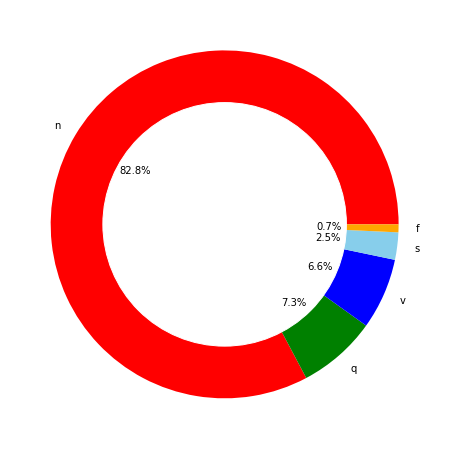

In [ ]:
plt.figure(figsize=(16,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Resampling

In [ ]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
equilibre=train_df[187].value_counts()
print(equilibre)


0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


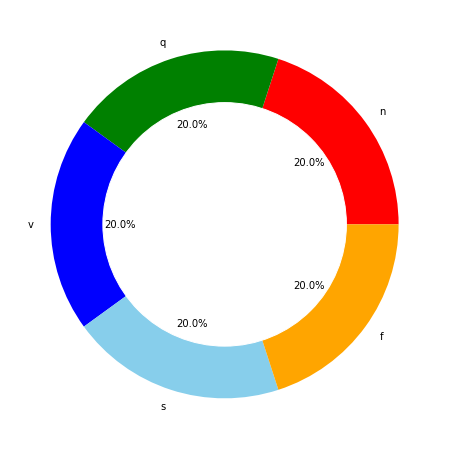

In [ ]:
plt.figure(figsize=(16,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# One sample from per class

In [ ]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
37754,1.000000,0.928205,0.683333,0.532051,0.515385,0.492308,0.453846,0.450000,0.453846,0.453846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74317,0.798942,0.465608,0.285714,0.343915,0.280423,0.264550,0.238095,0.253968,0.227513,0.253968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
78059,0.919214,0.873362,0.668122,0.347162,0.200873,0.148472,0.120087,0.109170,0.098253,0.080786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80491,0.964215,1.000000,0.827038,0.423459,0.248509,0.145129,0.125249,0.115308,0.109344,0.087475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
87166,0.971623,0.921680,0.861521,0.801362,0.733258,0.620885,0.502838,0.399546,0.332577,0.283768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


# ECG Signal Plot

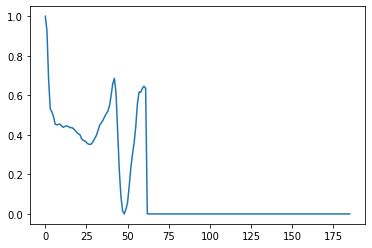

In [ ]:
 plt.plot(c.iloc[0,:186])

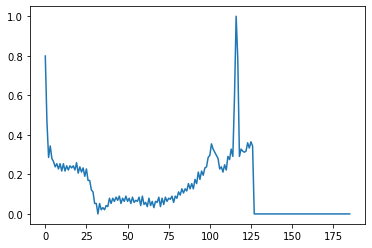

In [ ]:
 plt.plot(c.iloc[1,:186])

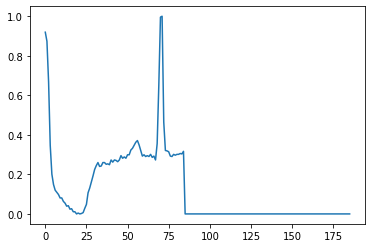

In [ ]:
 plt.plot(c.iloc[2,:186])

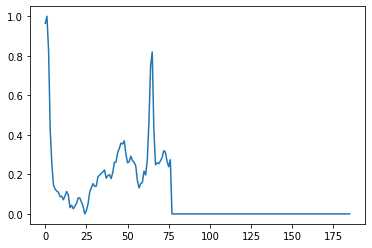

In [ ]:
plt.plot(c.iloc[3,:186])

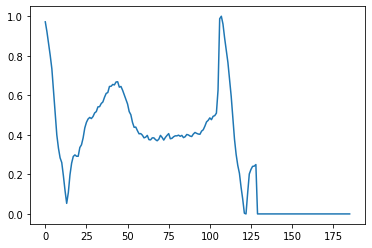

In [ ]:
plt.plot(c.iloc[4,:186])

# Transform data

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values


In [ ]:
np.array(X_train).shape

(100000, 186)

In [ ]:
np.array(y_train).shape

(100000, 5)

# **CNN**

In [ ]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=50,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history, model.summary())


In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [ ]:
X_train.shape

(100000, 186)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size = .10)
model,history,summary=network(X_train,y_train,X_val,y_val)
summary

Epoch 1/50
2813/2813 [==============================] - 29s 10ms/step - loss: 0.2022 - accuracy: 0.9279 - val_loss: 0.1299 - val_accuracy: 0.9545
Epoch 2/50
2813/2813 [==============================] - 19s 7ms/step - loss: 0.0806 - accuracy: 0.9731 - val_loss: 0.1160 - val_accuracy: 0.9604
Epoch 3/50
2813/2813 [==============================] - 19s 7ms/step - loss: 0.0513 - accuracy: 0.9828 - val_loss: 0.0781 - val_accuracy: 0.9748
Epoch 4/50
2813/2813 [==============================] - 19s 7ms/step - loss: 0.0426 - accuracy: 0.9861 - val_loss: 0.0496 - val_accuracy: 0.9846
Epoch 5/50
2813/2813 [==============================] - 23s 8ms/step - loss: 0.0315 - accuracy: 0.9895 - val_loss: 0.0427 - val_accuracy: 0.9895
Epoch 6/50
2813/2813 [==============================] - 30s 11ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.1172 - val_accuracy: 0.9648
Epoch 7/50
2813/2813 [==============================] - 28s 10ms/step - loss: 0.0242 - accuracy: 0.9921 - val_loss: 0.0371 - val

# Evaluation

Accuracy: 97.38%


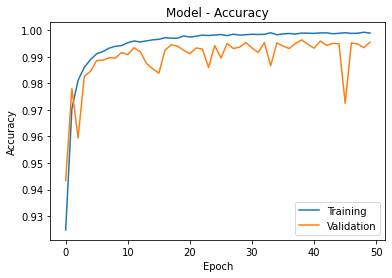

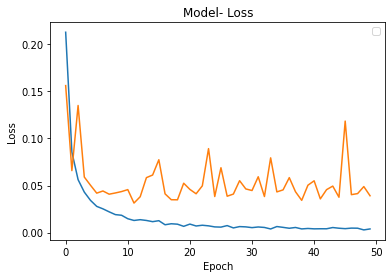

In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'CNN Loss & Accuracy Evolution')

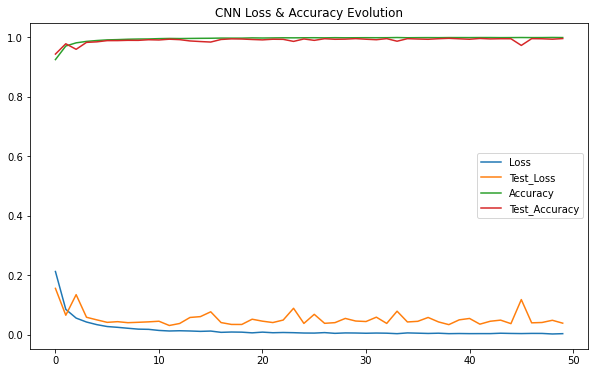

In [ ]:
#import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

#plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Test_Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Test_Accuracy')
plt.legend()
plt.title('CNN Loss & Accuracy Evolution')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.66      0.86      0.74       556
           2       0.93      0.96      0.95      1448
           3       0.63      0.86      0.73       162
           4       0.98      0.99      0.99      1608

    accuracy                           0.97     21892
   macro avg       0.84      0.93      0.88     21892
weighted avg       0.98      0.97      0.98     21892



Normalized confusion matrix


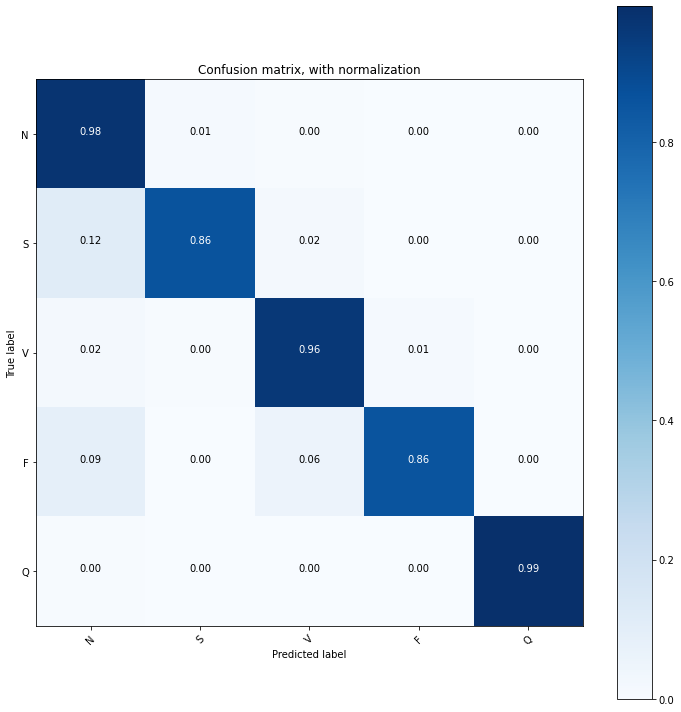

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()



In [ ]:
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.974
F1 Score: 0.974
Recall: 0.974
Accuracy: 0.974


# **ALexNet**

In [ ]:
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout 
from keras.models import Sequential
import tensorflow as tf

alexNet_model =  Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(186,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='softmax'))

In [ ]:
alexNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 44, 96)            1152      
                                                                 
 batch_normalization_3 (Batc  (None, 44, 96)           384       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 22, 96)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 22, 256)           123136    
                                                                 
 batch_normalization_4 (Batc  (None, 22, 256)          1024      
 hNormalization)                                                 
                                                        

In [ ]:
alexNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
X_train.shape

(100000, 186)

In [ ]:
y_train.shape

(100000, 5)

In [ ]:
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
alexNet_model_history = alexNet_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 35s 11ms/step - loss: 0.3459 - accuracy: 0.8846 - val_loss: 0.2580 - val_accuracy: 0.9084
Epoch 2/50
3125/3125 [==============================] - 33s 11ms/step - loss: 0.1650 - accuracy: 0.9458 - val_loss: 0.2462 - val_accuracy: 0.9093
Epoch 3/50
3125/3125 [==============================] - 33s 11ms/step - loss: 0.1138 - accuracy: 0.9642 - val_loss: 0.1829 - val_accuracy: 0.9470
Epoch 4/50
3125/3125 [==============================] - 33s 11ms/step - loss: 0.0906 - accuracy: 0.9732 - val_loss: 0.2029 - val_accuracy: 0.9442
Epoch 5/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0782 - accuracy: 0.9781 - val_loss: 0.1444 - val_accuracy: 0.9584
Epoch 6/50
3125/3125 [==============================] - 33s 11ms/step - loss: 0.0644 - accuracy: 0.9815 - val_loss: 0.1478 - val_accuracy: 0.9647
Epoch 7/50
3125/3125 [==============================] - 33s 11ms/step - loss: 0.0576 - accuracy: 0.9845 - val_loss: 0.1776 -

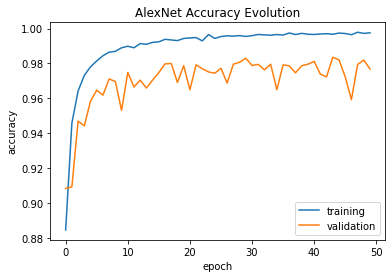

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(alexNet_model_history.history['accuracy'])
plt.plot(alexNet_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.title('AlexNet Accuracy Evolution')
plt.show()
plt.savefig('AlexNetAccuracy.png')

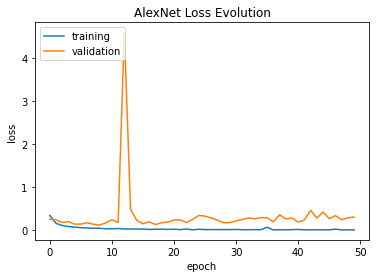

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(alexNet_model_history.history['loss'])
plt.plot(alexNet_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.title('AlexNet Loss Evolution')
plt.show()
plt.savefig('AlexNetLoss.png')

Text(0.5, 1.0, 'AlexNet Loss & Accuracy Evolution')

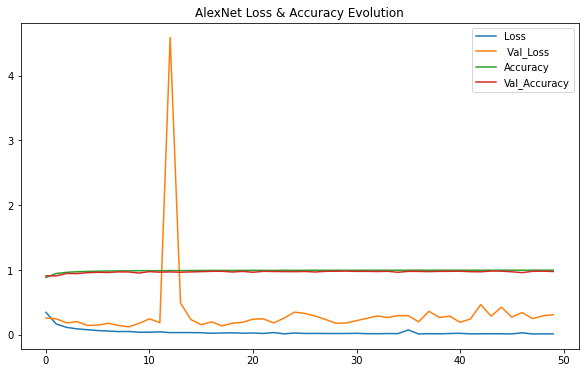

In [ ]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(alexNet_model_history.history['loss'], label='Loss')
plt.plot(alexNet_model_history.history['val_loss'], label=' Val_Loss')
plt.plot(alexNet_model_history.history['accuracy'], label='Accuracy')
plt.plot(alexNet_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('AlexNet Loss & Accuracy Evolution')

In [ ]:
y_true_alexnet=[]
for element in y_test:
    y_true_alexnet.append(np.argmax(element))
prediction_proba=alexNet_model.predict(X_test)
prediction_alexnet=np.argmax(prediction_proba,axis=1)

Normalized confusion matrix


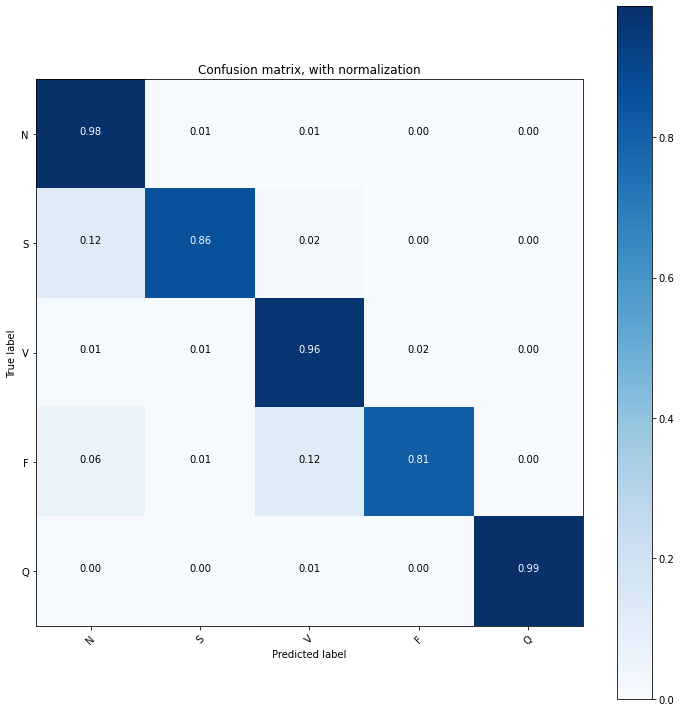

In [ ]:
alexnetConfMat = confusion_matrix(y_true_alexnet, prediction_alexnet)
#sns.heatmap(alexnetConfMat/np.sum(alexnetConfMat), annot=True,fmt='.3%', cmap='Blues')
#plt.savefig('AlexNetconfMat.png')

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(alexnetConfMat, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print('Precision: %.3f' % precision_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_alexnet, prediction_alexnet))

Precision: 0.977
F1 Score: 0.977
Recall: 0.977
Accuracy: 0.977


# **LSTM**

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(186,1)))
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(5, activation = 'softmax'))

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
X_train.shape

(100000, 186)

In [ ]:
y_train.shape

(100000, 5)

In [ ]:
lstm_model_history = lstm_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 33s 10ms/step - loss: 1.1315 - accuracy: 0.5400 - val_loss: 1.0997 - val_accuracy: 0.6242
Epoch 2/50
3125/3125 [==============================] - 35s 11ms/step - loss: 0.8605 - accuracy: 0.6877 - val_loss: 0.9630 - val_accuracy: 0.6589
Epoch 3/50
3125/3125 [==============================] - 30s 9ms/step - loss: 0.7803 - accuracy: 0.7173 - val_loss: 0.8859 - val_accuracy: 0.6424
Epoch 4/50
3125/3125 [==============================] - 33s 10ms/step - loss: 0.6773 - accuracy: 0.7597 - val_loss: 0.8239 - val_accuracy: 0.7209
Epoch 5/50
3125/3125 [==============================] - 38s 12ms/step - loss: 0.6575 - accuracy: 0.7647 - val_loss: 0.7459 - val_accuracy: 0.7413
Epoch 6/50
3125/3125 [==============================] - 39s 13ms/step - loss: 0.5341 - accuracy: 0.8120 - val_loss: 0.6718 - val_accuracy: 0.7798
Epoch 7/50
3125/3125 [==============================] - 28s 9ms/step - loss: 0.4808 - accuracy: 0.8314 - val_loss: 0.6226 - v

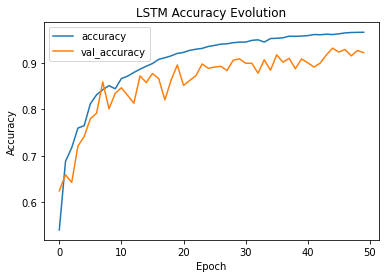

In [ ]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy Evolution')
plt.savefig('LSTMaccuracy.png')

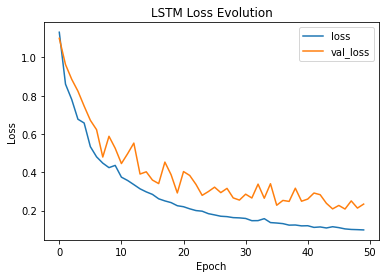

In [ ]:
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss Evolution')
plt.savefig('LSTMLoss.png')

Text(0.5, 1.0, 'LSTM Loss & Accuracy Evolution')

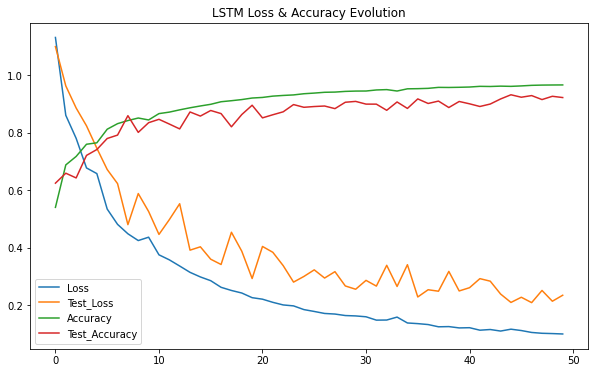

In [ ]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(lstm_model_history.history['loss'], label='Loss')
plt.plot(lstm_model_history.history['val_loss'], label='Test_Loss')
plt.plot(lstm_model_history.history['accuracy'], label='Accuracy')
plt.plot(lstm_model_history.history['val_accuracy'], label='Test_Accuracy')
plt.legend()
plt.title('LSTM Loss & Accuracy Evolution')

In [ ]:
y_true_lstm=[]
for element in y_test:
    y_true_lstm.append(np.argmax(element))
prediction_proba=lstm_model.predict(X_test)
prediction_lstm=np.argmax(prediction_proba,axis=1)

Normalized confusion matrix


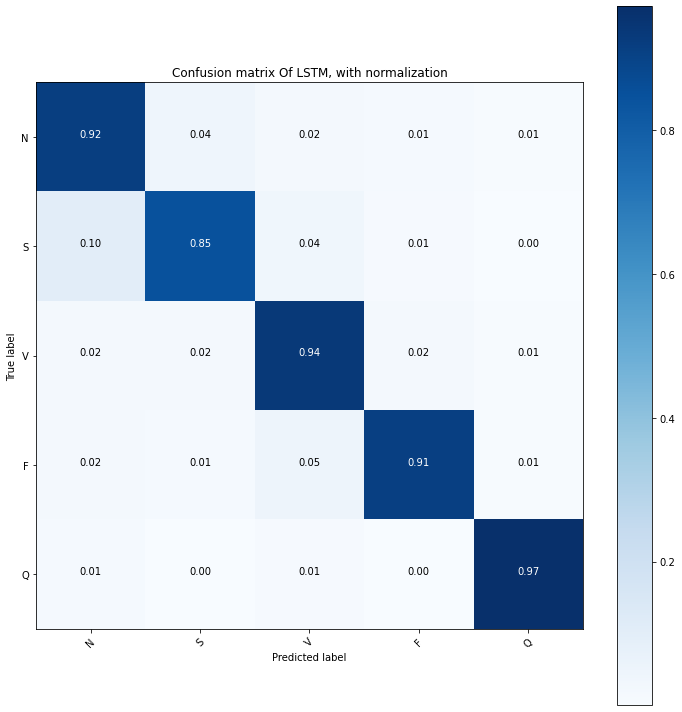

In [ ]:
lstmconfmat = confusion_matrix(y_true_lstm, prediction_lstm)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(lstmconfmat, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix Of LSTM, with normalization')
plt.show()



In [ ]:
print('Precision: %.3f' % precision_score(y_true_lstm, prediction_lstm, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_lstm, prediction_lstm, average='micro'))
print('Recall: %.3f' % recall_score(y_true_lstm, prediction_lstm, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_lstm, prediction_lstm))

Precision: 0.922
F1 Score: 0.922
Recall: 0.922
Accuracy: 0.922


# **LeNet**

In [ ]:
lenet_model=Sequential()

lenet_model.add(Conv1D(filters=6, kernel_size=3, padding='same', activation='relu', input_shape=(186,1)))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_model.add(Conv1D(filters=16, strides=1, kernel_size=5, activation='relu'))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_model.add(Flatten())

lenet_model.add(Dense(64, activation='relu'))

lenet_model.add(Dense(32, activation='relu'))

lenet_model.add(Dense(5, activation = 'softmax'))

In [ ]:
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 186, 6)            24        
                                                                 
 batch_normalization_3 (Batc  (None, 186, 6)           24        
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 93, 6)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 89, 16)            496       
                                                                 
 batch_normalization_4 (Batc  (None, 89, 16)           64        
 hNormalization)                                                 
                                                      

In [ ]:
lenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
X_train.shape

(100000, 186)

In [ ]:
y_train.shape

(100000, 5)

In [ ]:
lenet_model_history = lenet_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 50s 15ms/step - loss: 0.2261 - accuracy: 0.9196 - val_loss: 0.2120 - val_accuracy: 0.9279
Epoch 2/50
3125/3125 [==============================] - 34s 11ms/step - loss: 0.0927 - accuracy: 0.9692 - val_loss: 0.1963 - val_accuracy: 0.9414
Epoch 3/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0662 - accuracy: 0.9775 - val_loss: 0.3292 - val_accuracy: 0.8996
Epoch 4/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0516 - accuracy: 0.9827 - val_loss: 0.1942 - val_accuracy: 0.9482
Epoch 5/50
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0420 - accuracy: 0.9860 - val_loss: 0.1558 - val_accuracy: 0.9624
Epoch 6/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0333 - accuracy: 0.9891 - val_loss: 0.1997 - val_accuracy: 0.9522
Epoch 7/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0326 - accuracy: 0.9893 - val_loss: 0.1634 -

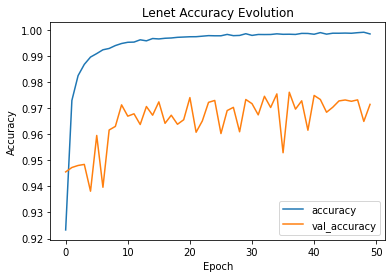

In [ ]:
plt.plot(lenet_model_history.history['accuracy'])
plt.plot(lenet_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Lenet Accuracy Evolution')
plt.savefig('Lenet Accuracy.png')

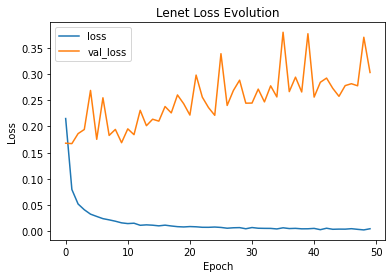

In [ ]:
plt.plot(lenet_model_history.history['loss'])
plt.plot(lenet_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Lenet Loss Evolution')
plt.savefig('Lenet Loss.png')

Text(0.5, 1.0, 'LeNet Loss & Accuracy Evolution')

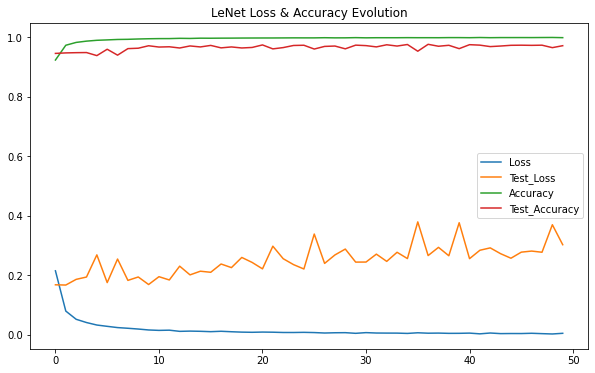

In [ ]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(lenet_model_history.history['loss'], label='Loss')
plt.plot(lenet_model_history.history['val_loss'], label='Test_Loss')
plt.plot(lenet_model_history.history['accuracy'], label='Accuracy')
plt.plot(lenet_model_history.history['val_accuracy'], label='Test_Accuracy')
plt.legend()
plt.title('LeNet Loss & Accuracy Evolution')

In [ ]:
y_true_lenet=[]
for element in y_test:
    y_true_lenet.append(np.argmax(element))
prediction_proba=lenet_model.predict(X_test)
prediction_lenet=np.argmax(prediction_proba,axis=1)

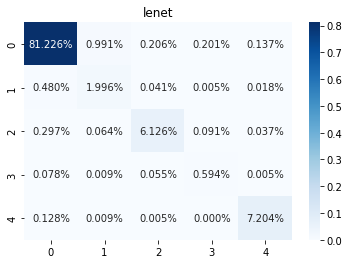

In [ ]:
lenetconfmat = confusion_matrix(y_true_lenet, prediction_lenet)
sns.heatmap(lenetconfmat/np.sum(lenetconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.title('lenet')
plt.savefig('lenet.png')

In [ ]:
print('Precision: %.3f' % precision_score(y_true_lenet, prediction_lenet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_lenet, prediction_lenet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_lenet, prediction_lenet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_lenet, prediction_lenet))

Precision: 0.971
F1 Score: 0.971
Recall: 0.971
Accuracy: 0.971


# ***VGG***

In [ ]:
vgg_model=Sequential()

vgg_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',  input_shape=(186,1)))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Flatten())
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(5, activation='softmax'))

In [ ]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 186, 64)           256       
                                                                 
 batch_normalization_3 (Batc  (None, 186, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 186, 64)           12352     
                                                                 
 batch_normalization_4 (Batc  (None, 186, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 93, 64)           0         
 1D)                                                             
                                                      

In [ ]:
X_train.shape

(100000, 186)

In [ ]:
y_train.shape

(100000, 5)

In [ ]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model_history = vgg_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 86s 25ms/step - loss: 0.3941 - accuracy: 0.8800 - val_loss: 0.2151 - val_accuracy: 0.9278
Epoch 2/50
3125/3125 [==============================] - 77s 25ms/step - loss: 0.2202 - accuracy: 0.9329 - val_loss: 0.3250 - val_accuracy: 0.9100
Epoch 3/50
3125/3125 [==============================] - 76s 24ms/step - loss: 0.1748 - accuracy: 0.9487 - val_loss: 0.3865 - val_accuracy: 0.8647
Epoch 4/50
3125/3125 [==============================] - 76s 24ms/step - loss: 0.1193 - accuracy: 0.9646 - val_loss: 0.3660 - val_accuracy: 0.8872
Epoch 5/50
3125/3125 [==============================] - 77s 25ms/step - loss: 0.0976 - accuracy: 0.9717 - val_loss: 0.1171 - val_accuracy: 0.9625
Epoch 6/50
3125/3125 [==============================] - 76s 24ms/step - loss: 0.1169 - accuracy: 0.9680 - val_loss: 0.1469 - val_accuracy: 0.9542
Epoch 7/50
3125/3125 [==============================] - 77s 25ms/step - loss: 0.0703 - accuracy: 0.9797 - val_loss: 0.2546 -

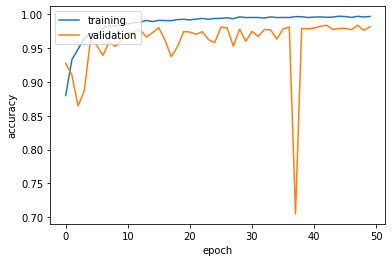

<Figure size 432x288 with 0 Axes>

In [ ]:
# summarize history for accuracy
plt.plot(vgg_model_history.history['accuracy'])
plt.plot(vgg_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.savefig('vgg Accuracy.png')


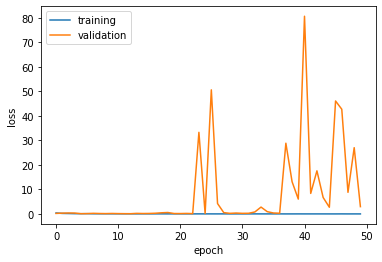

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(vgg_model_history.history['loss'])
plt.plot(vgg_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.savefig('vgg Loss.png')

Text(0.5, 1.0, 'VGG Loss & Accuracy Evolution')

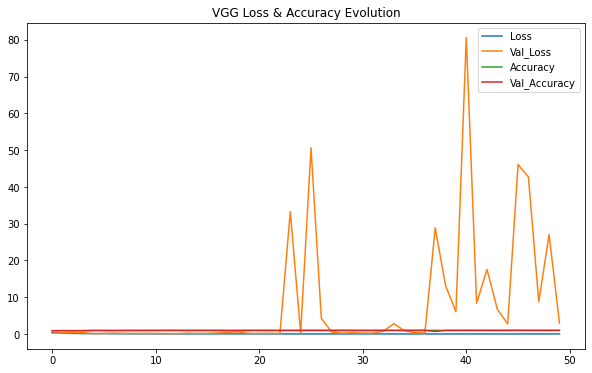

In [ ]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(vgg_model_history.history['loss'], label='Loss')
plt.plot(vgg_model_history.history['val_loss'], label='Val_Loss')
plt.plot(vgg_model_history.history['accuracy'], label='Accuracy')
plt.plot(vgg_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('VGG Loss & Accuracy Evolution')

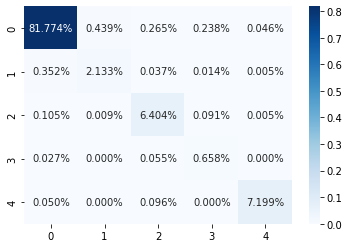

In [ ]:
y_true_vgg=[]
for element in y_test:
    y_true_vgg.append(np.argmax(element))
prediction_proba=vgg_model.predict(X_test)
prediction_vgg=np.argmax(prediction_proba,axis=1)

vggconfmat = confusion_matrix(y_true_vgg, prediction_vgg)
sns.heatmap(vggconfmat/np.sum(vggconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('vgg ConfMat.png')

In [ ]:
print('Precision: %.3f' % precision_score(y_true_vgg, prediction_vgg, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_vgg, prediction_vgg, average='micro'))
print('Recall: %.3f' % recall_score(y_true_vgg, prediction_vgg, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_vgg, prediction_vgg))

Precision: 0.982
F1 Score: 0.982
Recall: 0.982
Accuracy: 0.982
